## Course Code: DS4003
## Course Name: Principles and Techniques for Data Science
## Lab Session: 07 - Anomaly Detection 2


#### Objectives

You will be able to: 

- Gain a practical understanding of how various anomaly detection algorithms operate.
- Evaluate the results form anomaly detection.
- Confidently apply anomaly detection to new datasets

In [30]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt


# Today's Topics 

## (Outlier) Anomaly Detection 
* AUROC curve 
* PCA based method 
* Matrix Factorization 
* Matrix Factorization + kNN
* AutoEncoder 
* Angle Based Outlier Detector 
* Isolation Forest



# Additional Library 

# Datasets we will use:
* Wine Quality Dataset
* Friends Dataset (from Lecture)
* Arrhythmia Dataset (From Lecture)
* MNIST dataset (for AutoEncoder)

# Let's begin......

# Let's read all the dataset first 

In [31]:
import idx2numpy
red_wine = pd.read_csv("winequality-red.csv", sep=';')
arrhythmia_data = pd.read_csv('arrhythmia.csv')
arrhythmia_label = pd.read_csv('arrhythmia_true_labels.csv').to_numpy() 
friends_data = pd.read_csv('friends.csv')

# AUROC helper function 

In [32]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
def show_auroc(y_true, y_score, name): 
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot()
    plt.show()

# Other necessary imports

In [33]:
from pyod.utils.utility import standardizer 
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score 
from pyod.utils.data import generate_data 


#  We will start by applying PCA based Anomaly Detection on the red wine data

In [34]:
# your code here 
from pyod.models.pca import PCA 
std_data = standardizer(red_wine)
clf = PCA(n_components=2, contamination=0.1)
clf.fit(std_data)
labels = clf.labels_ 

# Next, we will visualize PCA components and color them with predicted label (inlier or outlier)

<Axes: xlabel='C1', ylabel='C2'>

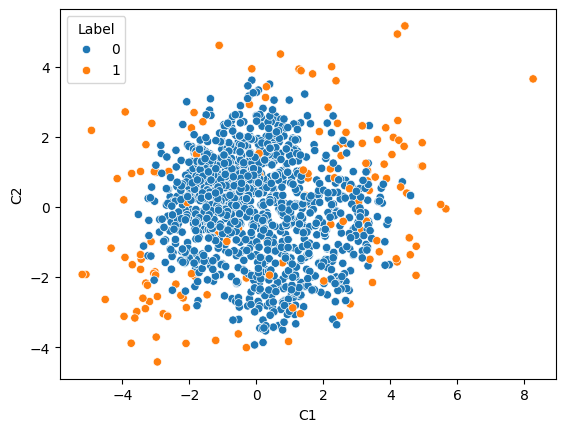

In [35]:
# your code here 
pca = clf.detector_.transform(std_data)
data = [[c[0], c[1], l] for c, l in zip(pca, labels)]
df = pd.DataFrame(data, columns=['C1', 'C2', 'Label'])
sns.scatterplot(data=df, x='C1', y='C2', hue='Label')

# Task 1: Apply the PCA based method on friends dataset from lecture. Visualize the results like we did previously. Can you explain the results?

In [36]:
friends_data.head()

,Name,Nearby,Funny,Loyal,Rich,Beautiful,Intelligent,Caring,Kind,Educated,OpenMind,Confidence,Fit,Teeth,Body,Nature,Independent,White,Muscular,Honest,SecureJob,Romantic,ShortHair,NonSmoker,Tall,Jewish,FamilyOR,BlueEye,RockMus,NoTattoo,SugarDad,LuxCar,LuxHouse,LuxBoat
0,Joey,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Chandler,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Ross,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Phoebe,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Rachel,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# your code here 


In [38]:
# your code here

# Matrix Factorization
We will now attempt to apply matrix factorization on the friends dataset. This has already been implemented for you. 

In [39]:
def matrix_factorization(R, K, alpha, beta, err_limit, n_iter):
    N = R.shape[0]
    M = R.shape[1]
    P = np.random.rand(N, K)
    Q = np.random.rand(K, M)
    for iteration in range(n_iter): 
        for i in range(N): 
            for j in range(M): 
                if R[i, j] > 0: 
                    eij = R[i, j] - P[i, :] @ Q[:, j]
                    for k in range(K): 
                        P[i, k] = P[i, k] + alpha * (2 * eij * Q[k, j] - beta * P[i, k])
                        Q[k, j] = Q[k, j] + alpha * (2 * eij * P[i, k] - beta * Q[k, j])
        e = 0 
        for i in range(N): 
            for j in range(M): 
                if R[i, j] > 0: 
                    e += (R[i, j] - P[i, :] @ Q[:, j])**2 
                    for k in range(K): 
                        e += (beta / 2) * (P[i, k]**2 + Q[k, j]**2)
        if e < err_limit:
            break
            
    return P, Q.T
    

In [40]:
data = friends_data.drop(columns="Name").values 
P, Q = matrix_factorization(data, K=1, alpha=2e-3, beta=2e-2, err_limit=1e-3, n_iter=10000)

# Task 2. Apply KNN based outlier detection on the P matrix from matrix factorization. Dont forget to visualize the results.

In [41]:
# your code here 


# AutoEncoder
We wil now look at AutoEncoders as discussed in the lectures.
In the example below, we will apply the AutoEncoder method to some randomly generated data.

In [42]:
from pyod.models.auto_encoder import AutoEncoder
import torch 

xtrain, ytrain = generate_data(n_train=200, n_test=100, n_features=2000, train_only=True, contamination=0.1)

device = torch.device('cpu')
clf = AutoEncoder(contamination=0.1, device=device)
clf.fit(xtrain)

Training: 100%|██████████| 10/10 [00:00<00:00, 35.61it/s]


# Since we have the labels, we can visualize the ROC curve and calculate the AUC

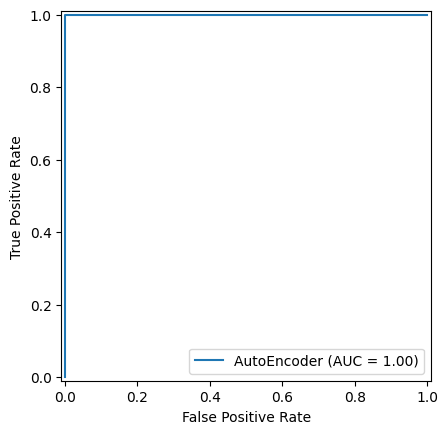

1.0


In [43]:
y_train_score = clf.labels_ 
show_auroc(y_true=ytrain, y_score=clf.decision_scores_, name="AutoEncoder")
acc = np.sum((ytrain == y_train_score)) / ytrain.shape[0]
print(acc)

# Task 3: Apply AutoEncoder from pyod library on arrythmia dataset 

## Task 3.1: Prepare data for AutoEncoder



In [44]:
# your code here 


## Task 3.2: Apply AutoEncoder from pyod library on the data and visualize the roc curve

In [45]:
# your code here 


## Task 3.3 Visualize the results using the ROC.

# Angle Based Outlier Detector (ABOD)

## First, let's try ABOD on a synthetically generated dataset. we will also visualize the ROC curve and the compute the AUC

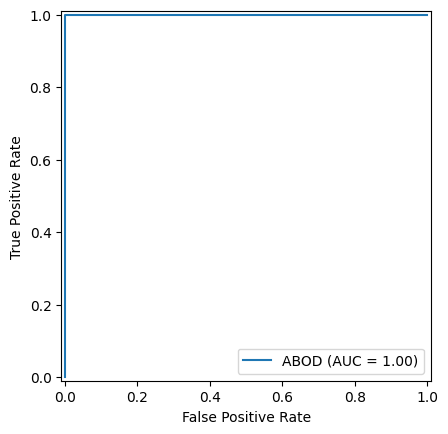

In [46]:

from pyod.models.abod import ABOD 
clf = ABOD(contamination=0.1)
clf.fit(xtrain)
labels = clf.labels_ 
scores = clf.decision_scores_ 
show_auroc(y_true=ytrain, y_score=scores, name="ABOD")

# Task: Let's apply ABOD on Friends data

Can you explain the result?

In [47]:
# your code here


# Task: Let's try it on arrhythmia dataset

In [48]:
# your code here 


# Isolation Forest

In this section, we will apply Isolation Forest on the friends data.

<Axes: xlabel='Name', ylabel='C1'>

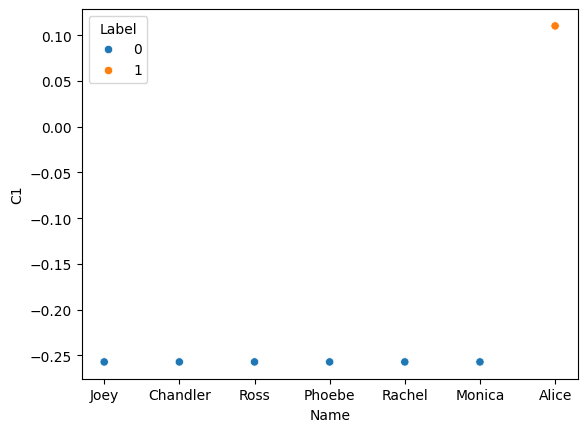

In [49]:
from pyod.models.iforest import IForest 
names = friends_data["Name"].values 
data = friends_data.drop(columns="Name").values 
std_data = standardizer(data)
clf = IForest(contamination=0.05, n_estimators=1, max_features=1)
clf.fit(std_data)
labels = clf.labels_ 
scores = clf.decision_scores_ 
data = [[name, c, l] for name, c, l in zip(names, scores, labels)]

df = pd.DataFrame(data, columns=["Name", "C1", "Label"])
sns.scatterplot(data=df, x='Name', y="C1", hue="Label")

# Task: Apply Isolation forest for arrhythmia dataset 


In [50]:
# your code here 


# Task: Apply Isolation Forest on Red Wine data and visualize the results

In [51]:
# your code here